In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
from os import walk
import os
import peakutils
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from scipy.integrate import simps
#from numpy import trapz

In [81]:
#############################
# run number and resolution #   
#############################

run_number = [99]
resol = [1] # half of the width in eV 
skiprows= 40

#############################


folder_path ='/Volumes/Work/P64'
#folder_path ='/Users/hsin-yiwang/Desktop/P64'
data_path =folder_path + "/" + 'r%04d'%run_number[0]

def discover_datas(path):
    for (dirpath, dirnames, datanames) in walk(path):
        break
    if len(datanames) != 0 :
        mask = np.ones(len(datanames), dtype=bool) 
        for i in np.arange(len(datanames)) :
            if datanames[i] =='image' : 
                mask[i] = 0
            elif len(datanames[i]) < 17:
                mask[i] = 0
            elif datanames[i][-3:] !='xes':
                mask[i] = 0
            
        datanames = np.array(datanames)
        datanames = datanames[mask]
    return datanames

XES_file = discover_datas(data_path)
XES_file.sort()
XES_file = np.delete(XES_file,[0,1,2,3,4])
#print(XES_file)

InEnergy = []
EmissionEnergySceale = []
RIXSmap = []
max_pos = np.zeros(len(XES_file)-3)
NormalEmission = []

for j in range(len(XES_file)-3):
    InE = XES_file[j][XES_file[j].find('r%04d' %run_number[0],0)+16:XES_file[j].find('.xes',0)]
    InE = float(InE)
    InEnergy.append(InE)

for i in range(len(XES_file)):
    data = pd.read_csv(data_path + '/' + XES_file[i], sep='\s', header = None, skiprows= skiprows)
    CSV_save_path = data_path+'/CSV/'  
    if not os.path.exists(os.path.join(CSV_save_path)):
        os.makedirs(os.path.join(CSV_save_path))
    data.to_csv(CSV_save_path  + XES_file[i][0:-3]+'csv', sep = ',')
    ColumnsName = ['Energy','Iav','I1','I2','I3','I4','I5','I6']
    CSVdata = pd.read_csv(CSV_save_path + XES_file[i][0:-3]+'csv', sep=',', skiprows =0, index_col=0)
    CSVdata.columns = ColumnsName
    Matrix = CSVdata.as_matrix(columns=CSVdata.columns[0:])
    baseline_values = peakutils.baseline(Matrix[:,1])
    Matrix[:,1] = Matrix[:,1] - baseline_values 
    if i == 0:
        EmissionEnergyScale = Matrix[:,0]
    if i < len(XES_file)-3:      
        RIXSmap.append(Matrix[:,1])
        max_pos[i] = np.argmax(Matrix[:,1], axis=0)
    else:
        NormalEmission.append(Matrix[:,1]) 

InEnergy = np.array(InEnergy)
EmissionEnergyScale = np.array(EmissionEnergyScale)
RIXSmap = np.array(RIXSmap).T
max_pos = np.array(max_pos)
Best_pos = int(round(np.average(max_pos[40:])))
NormalEmission = np.array(NormalEmission)

HerProfile = []
for k in range(len(XES_file)-3):
    Emissionline = RIXSmap.T[k,:]
    HerInt = float(Emissionline[Best_pos])*int(resol[0]) + float(Emissionline[Best_pos+1])*int(resol[0])/2 + float(Emissionline[Best_pos-1])*int(resol[0])/2
    HerProfile.append(HerInt)
HerProfile = np.array(HerProfile)
    
Normal_point = []    
for m in range(3):
    Temp = NormalEmission[m,:]
    NorInt =  float(Temp[Best_pos])*int(resol[0]) + float(Temp[Best_pos+1])*int(resol[0])/2 + float(Temp[Best_pos-1])*int(resol[0])/2
    Normal_point.append(NorInt)
Nor_point = float(np.average(Normal_point))
Nor_BL = float(np.average(HerProfile[5:15]))

HerProfile = (HerProfile-Nor_BL)/Nor_point
    
xmin = float(InEnergy[0])
xmax = float(InEnergy[-1])
ymin = (EmissionEnergyScale[0])
ymax = (EmissionEnergyScale[-1])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


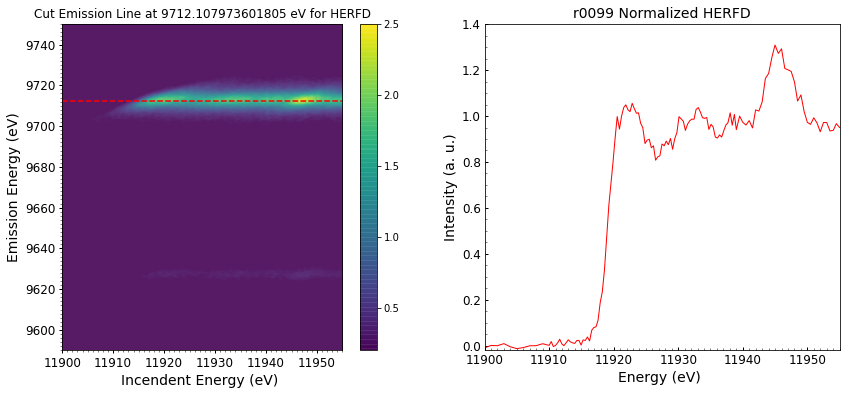

In [82]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

Result_save_path = folder_path+'/Image_result/'  
if not os.path.exists(os.path.join(Result_save_path)):
    os.makedirs(os.path.join(Result_save_path))

Adj_Best_pos = ymin + ((ymax-ymin)/len(EmissionEnergyScale))*Best_pos
#print("Cut Emission Line at " + str(Adj_Best_pos) + ' eV for HERFD')

plt.figure(figsize=[14,6])   

ax=plt.subplot(1,2,1)
plt.imshow(RIXSmap, vmin=0.2,vmax=2.5, origin='lower', interpolation='bicubic', alpha = 0.9, extent=[xmin,xmax,ymin,ymax])
plt.title('r%04d' %run_number[0] + ' RIXS MAP',size = 14)
plt.title("Cut Emission Line at " + str(Adj_Best_pos) + ' eV for HERFD')
plt.axhline(y=Adj_Best_pos, ls='--',c='red',lw=1.5)
plt.xlim(11900,11955)
plt.ylim(9590,9750)
plt.xlabel('Incendent Energy (eV) ',size=14)
plt.ylabel('Emission Energy (eV)',size=14)
plt.tick_params(direction='out', length=3, width=1, axis='both', which='major', labelsize=12)
plt.tick_params(direction='out', length=2, width=0.5, axis='both', which='minor', labelsize=12)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(2))
plt.colorbar()
ax.set_aspect(aspect=0.4)

ax = plt.subplot(1,2,2)
plt.plot(InEnergy,HerProfile,lw=1, c='r', ls='-')
plt.title('r%04d' %run_number[0] + ' Normalized HERFD', size = 14)
plt.xlim(11900,11955)
plt.ylim(-0.02,1.4)
plt.xlabel('Energy (eV) ',size=14)
plt.ylabel('Intensity (a. u.)',size=14)
plt.tick_params(direction='in', length=3, width=1, axis='both', which='major', labelsize=12)
plt.tick_params(direction='in', length=2, width=0.5, axis='both', which='minor', labelsize=12)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.savefig(Result_save_path + 'Result_r%04d'%run_number[0]+'.png', dpi=300)
plt.show()


HERFD_save_path = folder_path+'/HERFD/'  
if not os.path.exists(os.path.join(HERFD_save_path)):
    os.makedirs(os.path.join(HERFD_save_path))
    
HERFD = os.path.join(HERFD_save_path, 'HERFD_r%04d'%run_number[0] + ".txt")         
with open (HERFD, "w") as out_file:
    for i in range(len(InEnergy)):
        out_string = ""
        out_string += str(InEnergy[i])
        out_string += ","+str(HerProfile[i])
        out_string += "\n"
        out_file.write(out_string)